In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
# Для воспроизводимости

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# RNN intro

Давайте разберемся что из себя вообще представляют рекуррентные нейронные сети в самом простом виде.

<img src="./pics/rnn.png" width="90%">

В самом простом виде для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ -- входной вектор на текущем шаге
* $y(t)$ -- выходной вектор на текущем шаге
* $w_x$ -- вектор весов нейронов для входа
* $w_y$ -- вектор весов нейронов для выхода
* $y(t-1)$ -- выходной вектор с прошлого шага. Для шага 0 этот вектор нулевой
* $b$ -- байес (bias)
* $\phi$ -- обозначение для функции активации, например ReLU


Есть понятие **hidden_state** ( $h(t)$ ) -- это "память" рекуррентной ячейки.

В общем случае $h_{(t)} = f(h_{(t-1)}, x_{(t)})$, но выход также $y{(t)} = f(h{(t-1)}, x{(t)})$.

В данном случае $h(t) == y(t)$, но на практике используются более сложные архитектуры и в них **hidden_state** не совпадает с непосредственным выходом нейросетки.

------

## Напишем свою простую RNN сеть

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в скобках квадратных -- конкатенация матриц

По размерностям:
* $Y_{(t)}$ -- матрица [$m$ x n_neurons]
* $X_{(t)}$ -- матрица [$m$ x n_features]
* $b$ -- вектор длины n_neurons
* $W_x$ -- веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ -- веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

In [3]:
reset_graph()

# Напишем нейронку прямо как на картинке в самом верху с 5-ю нейронами
# На вход будем подавать векторы длины 3
n_features = 3
n_neurons = 5

# С текушей имплементацией наша нейронка делает всего 2 шага
X0 = tf.placeholder(tf.float32, [None, n_features])
X1 = tf.placeholder(tf.float32, [None, n_features])

Wx = tf.Variable(tf.random_normal(shape=[n_features, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

# Здесь в качестве функции phi берем гиперболический тангенс
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
# Будем подавать на вход мини батчи размером 4
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])  # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])  # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
Y0_val

array([[-0.0664006 ,  0.96257669,  0.68105787,  0.70918542, -0.89821595],
       [ 0.9977755 , -0.71978885, -0.99657625,  0.9673925 , -0.99989718],
       [ 0.99999774, -0.99898815, -0.99999893,  0.99677622, -0.99999988],
       [ 1.        , -1.        , -1.        , -0.99818915,  0.99950868]], dtype=float32)

In [6]:
Y1_val

array([[ 1.        , -1.        , -1.        ,  0.40200216, -1.        ],
       [-0.12210433,  0.62805319,  0.96718419, -0.99371207, -0.25839335],
       [ 0.99999827, -0.9999994 , -0.9999975 , -0.85943311, -0.9999879 ],
       [ 0.99928284, -0.99999815, -0.99990582,  0.98579615, -0.92205751]], dtype=float32)

## Задание

Напишите то же самое, но использовав всего одно матричное перемножение на каждом шаге (см формулу в объяснении выше)

In [ ]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_features])
X1 = tf.placeholder(tf.float32, [None, n_features])

< здесь код объявления новых переменных, а также построения графа вычислений >

with tf.Session() as sess:
    init.run()
    Y0_val_1, Y1_val_1 = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

# Dynamic_rnn

В tf есть функция `tf.contrib.rnn.static_rnn` которая создает для каждого unrolling'а (т.е. каждого батча на входе) отдельную ячейку того типа, который мы ей передадим. В данном случае наша имплементация совпадает с имплементацией `tf.contrib.rnn.BasicRNNCell` в tf. Это все не очень круто, если требуется сделать большое число шагов -- у нас попросту может закончится память, если мы вдруг решим делать backprop. Поэтому к счастью есть другой путь -- это `dynamic_rnn`.

Сделаем весь предыдущий пример с помощью `dynamic_rnn`.

In [7]:
n_steps = 2
n_features = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_features])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [8]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [9]:
init = tf.global_variables_initializer()
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

# параметр с истинной длиной последовательностей
seq_length_batch = np.array([2, 1, 2, 2])

In [10]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [11]:
print(outputs_val.shape)
print(states_val.shape)

(4, 2, 5)
(4, 5)


In [12]:
# заметим, что у второго инпута есть нули в final state
print(outputs_val)

[[[-0.68579948 -0.25901747 -0.80249101 -0.18141513 -0.37491536]
  [-0.99996698 -0.94501185  0.98072106 -0.9689762   0.99966913]]

 [[-0.99099374 -0.64768541 -0.67801034 -0.7415446   0.7719509 ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99978048 -0.85583007 -0.49696958 -0.93838578  0.98505187]
  [-0.99951065 -0.89148796  0.94170523 -0.38407657  0.97499216]]

 [[-0.02052618 -0.94588047  0.99935204  0.37283331  0.9998163 ]
  [-0.91052347  0.05769409  0.47446665 -0.44611037  0.89394671]]]


In [13]:
# а тут уже нет нулей;
# так происходит благодаря наличию параметра seq_length
print(states_val)

[[-0.99996698 -0.94501185  0.98072106 -0.9689762   0.99966913]
 [-0.99099374 -0.64768541 -0.67801034 -0.7415446   0.7719509 ]
 [-0.99951065 -0.89148796  0.94170523 -0.38407657  0.97499216]
 [-0.91052347  0.05769409  0.47446665 -0.44611037  0.89394671]]


# Генерация имен

А теперь попробуем понять что можно со всем этим вышеперечисленным делать полезного.

_Teaser:_

* Сложно придумать имя для переменной? Но куда сложнее придумать хорошее имя для человека.
  Поэтому давайте напишем нейронку, которая сделает это за нас.
* Набор данных содержит ~ 8 тыс человеческих имен из разных культур [в латинской расшифровке]
* Цель (игрушечная проблема): изучить генеративную модель по именам.

In [20]:

start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name.lower() for name in names]

In [21]:
print('n samples = ', len(names))
for x in names[::1000]:
    print(x.strip().capitalize())

n samples =  7944
Abagael
Claresta
Glory
Liliane
Prissie
Geeta
Giovanne
Piggy


# Обработка текста

Рассмотрим все буквы без учета регистра + ')' -- конец имени

In [24]:
# Найдем все уникальные символы
# Без учета регистра

token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)


token_set.add(')')
tokens = list(token_set)
tokens.sort()

print('n_tokens = ', len(tokens))

n_tokens =  30


In [25]:
#!token_to_id = < словарь символов -> их id (index в tokens list)>
token_to_id = {t: i for i, t in enumerate(tokens)}

#!id_to_token = < словарь айдишников -> соответствующие символы >
id_to_token = {i: t for i, t in enumerate(tokens)}

## Построим распределение длин всех имен

15


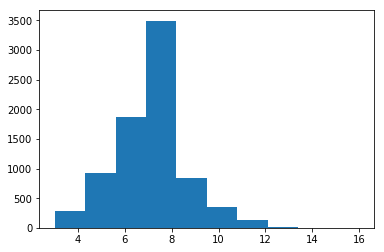

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)))

# Посмотрим какая максимальная длина у имени в этом датасете
MAX_LEN = min([60, max(list(map(len, names)))])-1

print(MAX_LEN)

### Переведем все символы в их id

In [28]:
names_ix = list(map(lambda name: list(map(token_to_id.get, name + ')')), names))


# Добьем нулями короткие имена до MAX_LEN и усечем слишком длинные
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN+1] #crop too long
    
    if len(names_ix[i]) < MAX_LEN+1:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN+1 - len(names_ix[i])) #pad too short
        
assert len(set(map(len, names_ix))) == 1

names_ix = np.array(names_ix)

In [29]:
names_ix[:10]

array([[ 0,  4,  5,  4, 10,  4,  8, 15,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  4, 10,  4, 12, 15,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  5,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  5,  8, 28,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  5, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  5, 12,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5,  5, 28,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5, 12, 10,  4,  8, 15,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5, 12, 10,  4, 12, 15,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  5, 12, 10,  4, 15,  8,  2,  0,  0,  0,  0,  0,  0,  0]])

## Генерилка батчей

In [30]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    x = rows[:, :-1]
    y = rows[:, 1:]
    
    count = lambda r: np.sum([id_to_token[t] != ' ' for t in r])
    lengths = list(map(count, x))
    
    return x, y, lengths

In [31]:
x, y, length = sample_batch(names_ix, 10)
y.shape

(10, 15)

In [32]:
x

array([[ 0, 21, 18, 17,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13, 18, 28,  6,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  4, 23, 11,  4, 21, 28, 17,  2,  0,  0,  0,  0,  0],
       [ 0, 16,  4, 24,  7, 12,  8,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12, 21, 25, 12, 17,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  4, 21, 17, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6, 18, 21, 21,  8, 17,  4,  2,  0,  0,  0,  0,  0,  0],
       [ 0, 25, 12,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10, 24,  8, 17,  8, 25,  8, 21,  8,  2,  0,  0,  0,  0],
       [ 0, 22, 11,  4, 28, 17,  8,  2,  0,  0,  0,  0,  0,  0,  0]])

In [33]:
y

array([[21, 18, 17,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [13, 18, 28,  6,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  4, 23, 11,  4, 21, 28, 17,  2,  0,  0,  0,  0,  0,  0],
       [16,  4, 24,  7, 12,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [12, 21, 25, 12, 17,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [16,  4, 21, 17, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6, 18, 21, 21,  8, 17,  4,  2,  0,  0,  0,  0,  0,  0,  0],
       [25, 12,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10, 24,  8, 17,  8, 25,  8, 21,  8,  2,  0,  0,  0,  0,  0],
       [22, 11,  4, 28, 17,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0]])

In [34]:
length

[5, 6, 9, 7, 6, 6, 8, 4, 10, 7]

# Входы сетки

In [35]:
reset_graph()

# подразумевается, что размерность X [batch_size, max_length];
X = tf.placeholder(tf.int32, [None, None], name= 'X')
y = tf.placeholder(tf.int32, [None, None], name = 'y')
lengths = tf.placeholder(tf.int32, [None], name = 'lengths')
learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[])

In [37]:
n_neurons = 60
embedding_size = 8
vocabulary_size = len(tokens)

n_steps = MAX_LEN # Этот параметр совпадает
                  # с максимальной длиной последовательности, 
                  # которая может быть подана на вход
                  # иначе говоря, это unrollings

# для входной последовательности создаем матрицу эмбеддингов
embedding_mtx = tf.get_variable(name='embeddings', shape=[vocabulary_size, embedding_size])

# достаем из матрицы эмбеддингов нужные нам векторы X
embed = tf.nn.embedding_lookup(embedding_mtx, X)


cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.tanh)
rnn_outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=embed,
                                        sequence_length=lengths, dtype=tf.float32)

# получаем ненормированное распределение по классам 
# для каждого анроллинга в каждом сэмле в батче
pred_logits = tf.layers.dense(inputs=rnn_outputs, units=vocabulary_size, name='output_projection')

# кодируем one-hot классы, т.к. это тоже нужно функции лосса
labels_one_hot = tf.one_hot(y, depth=vocabulary_size, dtype=tf.float32)

# считаем илололосс
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=labels_one_hot,
    logits=pred_logits)
    
loss = tf.reduce_mean(stepwise_cross_entropy)

pred_probas = tf.nn.softmax(pred_logits)

# берем максимум по оси, соответствующей количеству классов
# получаем матрицу размера [batch_size, num_steps]
prediction = tf.argmax(pred_probas, axis=2)

train_op = tf.train.AdamOptimizer(learning_rate_ph).minimize(loss)

# берем распределение вероятностей только для последнего символа в каждом сэмпле
# это потребуется для генерации
last_word_probas = pred_probas[:, -1]

### Как можно узнать о параметрах, которые тренируются

In [38]:
tf.trainable_variables()

[<tf.Variable 'embeddings:0' shape=(30, 8) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_rnn_cell/weights:0' shape=(68, 60) dtype=float32_ref>,
 <tf.Variable 'rnn/basic_rnn_cell/biases:0' shape=(60,) dtype=float32_ref>,
 <tf.Variable 'output_projection/kernel:0' shape=(60, 30) dtype=float32_ref>,
 <tf.Variable 'output_projection/bias:0' shape=(30,) dtype=float32_ref>]

### Напишем функцию, позволяющую генерить имена по затравке

*Что делается*

* Берется затравка (seed_phrase)
* Предсказывается вероятность появления следующего токена
* Следующий токен сэмплируется из распределения, предсказанного моделью
* Полученный токен добавляется к затравке
* Повторяем с шага 2

In [41]:
def generate_sample(sess, seed_phrase=None, N=MAX_LEN, n_snippets=1):
    
    if seed_phrase is None:
        seed_phrase = ' '
    elif seed_phrase[0].isalpha():
        seed_phrase = ' ' + seed_phrase
    seed_phrase = seed_phrase.lower()
    seed_phrase = np.array([token_to_id[tok] for tok in seed_phrase])
    L = len(seed_phrase)
    snippets = []
    for _ in range(n_snippets):
        x = np.zeros(N)
        x[:len(seed_phrase)] = seed_phrase
        for n in range(N - L):
            feed_dict = {X: x[:L + n].reshape([1, -1]), lengths: [len(x)]}
            p = sess.run(last_word_probas, feed_dict=feed_dict).reshape(-1)
            ix = np.random.choice(np.arange(len(tokens)), p=p)
            x[L + n] = ix
        snippet = ''.join([id_to_token[idx] for idx in x])
        if ')' in snippet:
            upto = snippet.index(')')
            snippet = snippet[:upto]
        snippets.append(snippet.strip().capitalize())
    return snippets

In [46]:
def print_pred(y_pred, k = 3):
    """
    k: сколько вывести 
    предсказаний модели среди всех y_pred
    
    """
    for i in range(k):
        print("".join( [id_to_token[t] for t in y_pred[i,:]]))

In [47]:
s = tf.Session()
    
s.run(tf.global_variables_initializer())

n_epochs = 5
batches_per_epoch = 500
batch_size = 10
lr = 1e-2
for epoch in range(n_epochs):

    print(">>Generated: ", generate_sample(s, n_snippets=6))
    print("-------\n")
    avg_cost = 0
    for batch in range(batches_per_epoch):
        x_, y_, len_ = sample_batch(names_ix, batch_size)

        _, iloss, y_pred = s.run([train_op, loss, prediction], {X: x_,
                                                                y: y_,
                                                                lengths: len_,
                                                                learning_rate_ph: lr})
        avg_cost += iloss

    print("EPOCH: ", epoch)
    print("AVERAGE LOSS: ", avg_cost/batches_per_epoch)
    print(">>Predicted: ")
    print_pred(y_pred)

print(">>Generated: ", generate_sample(s, n_snippets=6))

>>Generated:  ["Iz'm", 'Gmx uz', 'Szelmhazvjoblr', 'Lzogsaggjtltof', 'Uddle pkjynvan', 'Wnrg']
-------

EPOCH:  0
AVERAGE LOSS:  1.62943659818
>>Predicted: 
aesni)         
anrna)))       
aerlnae)       
>>Generated:  ['Erdisa', 'Eych', 'Eshie', 'Angostia', 'Astelie', 'Mesamet']
-------

EPOCH:  1
AVERAGE LOSS:  1.09818096185
>>Predicted: 
conii))e       
chardh))))     
cosi           
>>Generated:  ['Welisa', 'Jolia', 'Meto', 'Addor', 'Gresarde', 'Gwedy']
-------

EPOCH:  2
AVERAGE LOSS:  1.05015222597
>>Predicted: 
cart)i))       
cld)a          
caren          
>>Generated:  ['Marte', 'Costsa', 'Chento', 'Guaste', 'Patulee', 'Marista']
-------

EPOCH:  3
AVERAGE LOSS:  1.03293791163
>>Predicted: 
arristaaa)     
aala           
aanii)         
>>Generated:  ['Karrobelneot', 'Kalasina', 'Marche', 'Amoosta', 'Dieturah', 'Sisuinae']
-------

EPOCH:  4
AVERAGE LOSS:  1.01994612098
>>Predicted: 
meenn          
mariin)        
maldi)         
>>Generated:  ['Ckri-', 'Marcletta', 'Ally'

In [51]:
generate_sample(s, seed_phrase='Puti', n_snippets=12)

['Putileen',
 'Putisterne',
 'Putian',
 'Putiley',
 'Puticat',
 'Putine',
 'Putilleyntt',
 'Putint',
 'Putil',
 'Putiane',
 'Putiley',
 'Putilea']

In [52]:
generate_sample(s, seed_phrase='Q', n_snippets=6)

['Quilyn', 'Quricanne', 'Quertholina', 'Queby', 'Quera', 'Quudnia']

In [53]:
generate_sample(s, seed_phrase='Eug', n_snippets=6)

['Eugwellin', 'Eugry', 'Eugwon', 'Eugtia', 'Eugeldond', 'Eugwey']

In [54]:
generate_sample(s, seed_phrase='Lu', n_snippets=19)

['Luondem',
 'Lustileh',
 'Luzedie',
 'Luendaina',
 'Luscio',
 'Luzta',
 'Luaria',
 'Luggy',
 'Lury',
 'Lueltpa',
 'Luann',
 'Ludill',
 'Luuston',
 'Luene',
 'Lublynn',
 'Luskelyna',
 'Luelte',
 'Lustadinsh',
 'Lurislie']

### Попробуйте использовать несколько слоев рекуррентных сетей

* Попробуйте поменять код модели, встроив туда модуль как в примере в следующей ячейке;
* Попробуйте использовать другие cells: LSTM, GRU;
* Попробуй генерировать твиты, скачав [датасет](http://study.mokoron.com) или какой угодно другой датасет


In [ ]:
# Как ненапряжно замутить глубокую рекуррентную нейросеть

n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)